In [1]:
import socket
import pickle
import struct
import cv2
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import numpy as np

ocr = PaddleOCR(lang='en', use_textline_orientation=True)

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:715: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
The model(UVDoc) is not supported to run in MKLDNN mode! Using `paddle` instead!
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in C:\Users\HP\.paddlex\official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Listening on 5002...
Connected by ('192.168.137.62', 36296)

=== OCR for frame_1.png ===
OCR Results:
  Text: SILABS (Confidence: 0.96)
  Text: CP2102 (Confidence: 0.95)
  Text: FPCO3X (Confidence: 0.91)
  Text: 2433+ (Confidence: 0.97)


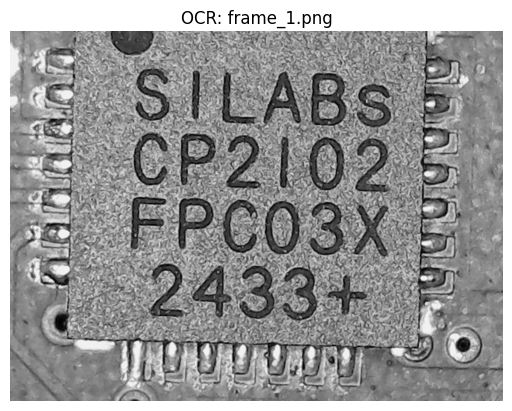


=== OCR for frame_2.png ===
OCR Results:
  Text: 33D420 (Confidence: 0.99)


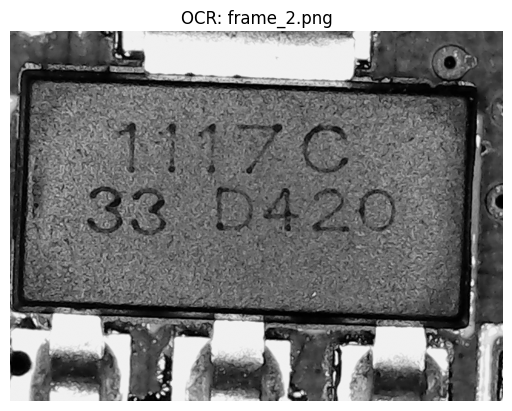


=== OCR for frame_3.png ===
OCR Results:
  Text: 74HC125 (Confidence: 0.99)
  Text: GAiPA833 (Confidence: 0.97)


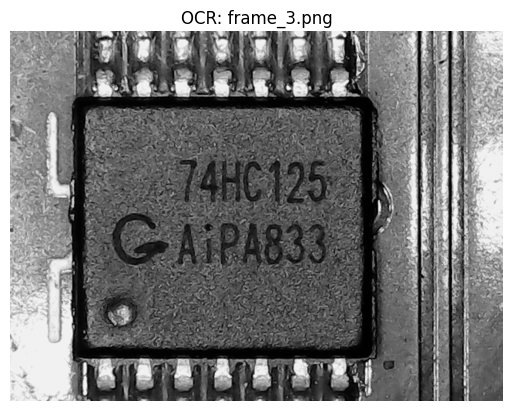


=== OCR for frame_4.png ===
OCR Results:
  Text: AMS1117 (Confidence: 0.99)
  Text: 3.3 XBLZ1 (Confidence: 0.93)


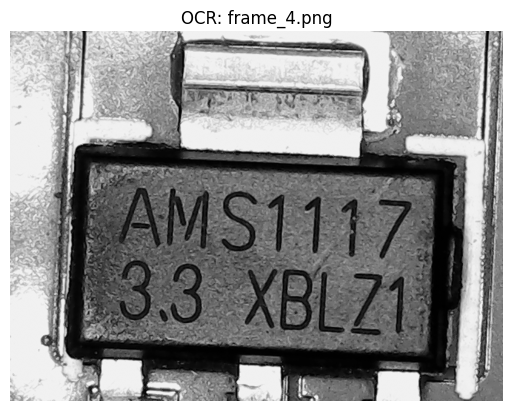


=== OCR for frame_5.png ===
OCR Results:
  Text: SS6A48H (Confidence: 1.00)
  Text: LM324 (Confidence: 0.99)


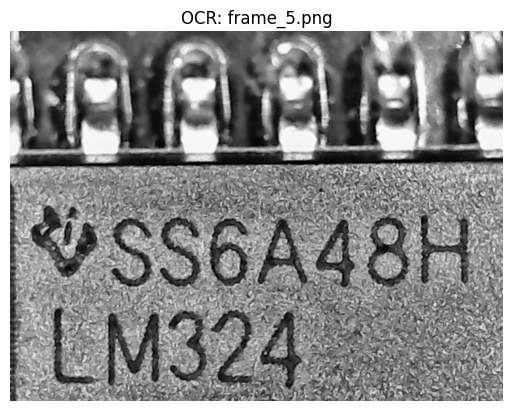


=== OCR for frame_6.png ===
OCR Results:
  Text: 33D135 (Confidence: 0.99)


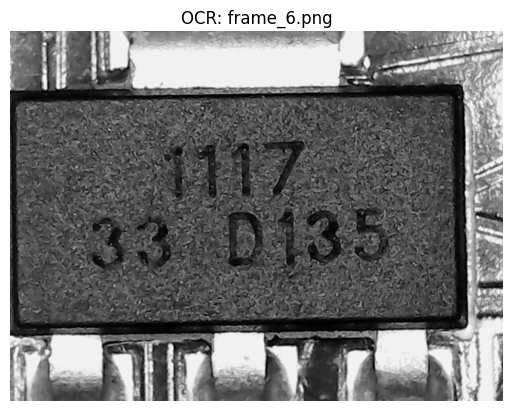


=== OCR for frame_7.png ===
OCR Results:
  Text: RCWL-9300C (Confidence: 0.99)
  Text: 20230401 (Confidence: 1.00)


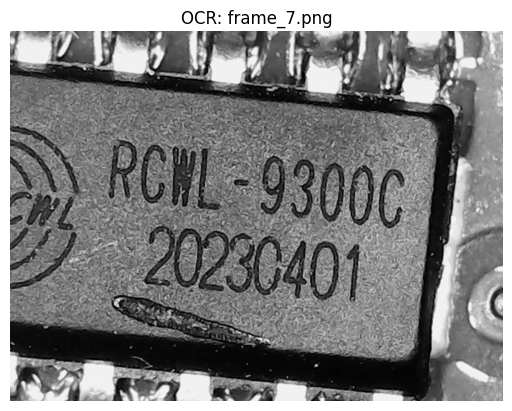

Server closed.


In [28]:
HOST = '0.0.0.0'
PORT = 5002

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.bind((HOST, PORT))
sock.listen(1)
print(f"Listening on {PORT}...")

conn, addr = sock.accept()
print(f"Connected by {addr}")

def recv_all(sock, length):
    data = b''
    while len(data) < length:
        more = sock.recv(length - len(data))
        if not more:
            return None
        data += more
    return data

# Open a file to save all OCR results
output_file_path = "ocr_results.txt"
with open(output_file_path, "w", encoding='utf-8') as f:
    while True:
        raw_size = recv_all(conn, 8)
        if not raw_size:
            break
        size = struct.unpack("Q", raw_size)[0]
        if size == 0:
            break

        payload = recv_all(conn, size)
        filename, image = pickle.loads(payload)

        print(f"\n=== OCR for {filename} ===")

        # Convert grayscale to BGR for OCR  
        bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        result = ocr.predict(bgr)
        entry = result[0]
        texts = entry.get('rec_texts', [])
        scores = entry.get('rec_scores', [])

        f.write(f"\n=== OCR for {filename} ===\n")
        print("OCR Results:")
        for text, score in zip(texts, scores):
            if score >= 0.7:
                print(f"  Text: {text} (Confidence: {score:.2f})")
                f.write(f"  Text: {text} (Confidence: {score:.2f})\n")

        plt.imshow(image, cmap='gray')
        plt.title(f"OCR: {filename}")
        plt.axis('off')
        plt.show()

conn.close()
sock.close()
print("Server closed.")
